# 고객 대출등급 예측 데이터셋
- multi-class 데이터셋
- 학습 데이터
    - https://drive.google.com/file/d/14IjwnpOHB7NBgEiujPErY3C5X5E6LAzi/view?usp=sharing
- 평가 데이터
    - https://drive.google.com/file/d/13B0Kstc31VQxxsu5nm6RhKlGTehdhrPD/view?usp=sharing

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
DATA_PATH = "/content/drive/MyDrive/the_datas/data/"
SEED = 42

In [214]:
import pandas as pd
import numpy as np

train_ft = pd.read_csv(f"{DATA_PATH}train_ft_길선종_처리전.csv")
test_ft = pd.read_csv(f"{DATA_PATH}test_ft_길선종_처리전.csv")
train_ft.shape, test_ft.shape

((14940, 443), (12225, 443))

In [211]:
import pandas as pd
import numpy as np

train_tr = pd.read_csv(f"{DATA_PATH}train_tr_common_1.csv") # 학습용 구매기록 데이터
train_target = pd.read_csv(f"{DATA_PATH}store_train.csv") # 학습용 정답 데이터
test_tr = pd.read_csv(f"{DATA_PATH}test_tr_common_1.csv") # 테스트용 구매기록 데이터
submit = pd.read_csv(f"{DATA_PATH}store_submission.csv") # 제출 양식 데이터

train_tr.shape , train_target.shape , test_tr.shape , submit.shape

((523105, 12), (14940, 2), (441196, 12), (12225, 2))

In [28]:
train_ft.head()

구매횟수      내점일수      구매주기    봄_구매비율   여름_구매비율   가을_구매비율   겨울_구매비율  \
0 -0.437126 -0.369867  0.002987 -1.029777  0.001191  0.838272  0.338186   
1  0.239394  0.144110 -0.356452  0.323951 -0.390607  0.620171 -0.552996   
2  1.890101  1.943028 -0.869935  0.798943 -0.514333 -0.304527 -0.059266   
3  4.298510  3.793345 -1.023980  0.420933 -0.327474  0.008592 -0.135636   
4  0.618244  0.452496 -0.613193 -0.752532  1.707410 -0.130285 -0.821561   

      주구매요일  12시이전구매비율  12시이후_18시이전구매비율  ...  최대구매액_대분류_19  최대구매액_대분류_20  \
0  0.109631   0.718557        -0.654150  ...     -0.193649     -0.131248   
1  0.109631   0.269465        -0.542415  ...     -0.193649     -0.131248   
2 -1.643370  -0.209830         0.532172  ...     -0.193649     -0.131248   
3  0.109631  -0.009001         0.054536  ...     -0.193649     -0.131248   
4  0.693965  -0.346226         0.591326  ...     -0.193649     -0.131248   

   최대구매액_대분류_21  최대구매액_대분류_22  최대구매액_대분류_23  최대구매액_대분류_24  최대구매액_대분류_25  \
0      -0.07785       -0.1402     -0.200973     -0.090737     -0.071977   
1      -0.07785       -0.1402     -0.200973     -0.090737     -0.071977   
2      -0.07785       -0.1402     -0.200973     -0.090737     -0.071977   
3      -0.07785       -0.1402     -0.200973     -0.090737     -0.071977   
4      -0.07785       -0.1402     -0.200973     -0.090737     -0.071977   

   최대구매액_대분류_26  최대구매액_대분류_27  최대구매액_대분류_28  
0     -0.146044     -0.067118     -0.050497  
1     -0.146044     -0.067118     -0.050497  
2     -0.146044     -0.067118     -0.050497  
3     -0.146044     -0.067118     -0.050497  
4     -0.146044     -0.067118     -0.050497  

[5 rows x 499 columns]

# 브랜드코드

In [111]:
train_brand = train_tr.groupby("브랜드코드").count().reset_index()[["브랜드코드"]]
train_brand

브랜드코드
0      5100
1      5101
2      5102
3      5103
4      5104
...     ...
1825   6990
1826   6992
1827   6994
1828   6995
1829   6996

[1830 rows x 1 columns]

In [112]:
train_brand_result = train_tr.groupby("브랜드코드").count().reset_index()[["브랜드코드"]]
train_brand_result

브랜드코드
0      5100
1      5101
2      5102
3      5103
4      5104
...     ...
1825   6990
1826   6992
1827   6994
1828   6995
1829   6996

[1830 rows x 1 columns]

## 특성 생성

In [113]:
train_tr['구매일시'] = pd.to_datetime(train_tr['구매일시'])

In [114]:
agg_list = [
        # 컬럼명, 집계 방식
        ('거래횟수','nunique'),
        ('내점일수', lambda x: x.dt.date.nunique()),
        ('구매주기', lambda x: int( (x.max() - x.min()).days / x.dt.date.nunique()) ),

        ('봄_구매비율', lambda x: np.mean(x.dt.month.isin([3,4,5]))),
        ('여름_구매비율', lambda x: np.mean(x.dt.month.isin([6,7,8]))),
        ('가을_구매비율', lambda x: np.mean(x.dt.month.isin([9,10,11]))),
        ('겨울_구매비율', lambda x: np.mean(x.dt.month.isin([1,2,12]))),
        ('주구매요일', lambda x: x.dt.weekday.mode()[0]),

        #추가 내용
        ('12시이전구매비율', lambda x: np.mean(x.dt.hour <= 12)),
        ('12시이후_18시이전구매비율', lambda x: np.mean((x.dt.hour > 12) & (x.dt.hour < 18))),
        ('18시이후구매비율', lambda x: np.mean(x.dt.hour >= 18)),
        ('주중방문비율', lambda x : np.mean(x.dt.weekday < 5)),
        ('주말방문비율', lambda x : np.mean(x.dt.weekday >= 5)),
        ('평일_18시_구매비율', lambda x: ((x.dt.weekday < 5) & (x.dt.hour >= 18)).mean()),
        ('방문평균거래평균횟수', lambda x: x.nunique()/x.dt.date.nunique()),

        ('금토일방문비율', lambda x : np.mean(x.dt.weekday >= 4)),
        ('금오후토일방문비율', lambda x: np.mean((x.dt.weekday >= 5) | ((x.dt.weekday == 4) & (x.dt.hour >= 18)))),
        #('월화수방문비율', lambda x : np.mean(x.dt.weekday < 3)),

        ('주구매시간', lambda x: x.dt.hour.mode()[0] if len(x.dt.hour.mode()) > 0 else -1),



    ]

tmp = train_tr.groupby('브랜드코드')["구매일시"].agg(agg_list).reset_index()
train_brand = train_brand.merge(tmp, how='left',on="브랜드코드")
train_brand.head()

브랜드코드   거래횟수  내점일수  구매주기    봄_구매비율   여름_구매비율   가을_구매비율   겨울_구매비율  주구매요일  \
0   5100  19018   337     1  0.256424  0.253779  0.238345  0.251453      4   
1   5101    730   292     1  0.301442  0.234600  0.200524  0.263434      4   
2   5102    277   169     2  0.308772  0.189474  0.249123  0.252632      3   
3   5103    295   177     2  0.173633  0.279743  0.247588  0.299035      3   
4   5104   1661   310     1  0.285080  0.081531  0.356628  0.276761      4   

   12시이전구매비율  12시이후_18시이전구매비율  18시이후구매비율    주중방문비율    주말방문비율  평일_18시_구매비율  \
0   0.182722         0.594636   0.222642  0.774654  0.225346     0.174342   
1   0.167759         0.592398   0.239843  0.788991  0.211009     0.184797   
2   0.214035         0.603509   0.182456  0.807018  0.192982     0.164912   
3   0.147910         0.565916   0.286174  0.771704  0.228296     0.205788   
4   0.165835         0.589573   0.244592  0.814199  0.185801     0.203550   

   방문평균거래평균횟수   금토일방문비율  금오후토일방문비율  주구매시간  
0   56.433234  0.413140   0.271194     17  
1    2.500000  0.402359   0.263434     15  
2    1.639053  0.392982   0.252632     15  
3    1.666667  0.427653   0.282958     19  
4    5.358065  0.388242   0.242374     18

In [115]:
agg_list = [
        ('총구매액','sum'),
        ('구매건수', 'count'),
        ('평균구매액', "mean"),
        ('최대구매액', 'max'),
        ('최소구매액',lambda x: x[x > 0].min() ) ,
        ('환불금액',lambda x: x[x < 0].sum() ) ,
        ('환불건수', lambda x: ( x < 0 ).sum() ),
        ('구매금액표준편차',lambda x: x[x>0].std() ),

        #추가내용
        ('구매금액왜도', lambda x: x[x > 0].skew()),
        ('구매금액첨도', lambda x: x[x > 0].kurtosis()),
        ('구매금액_1q', lambda x: x[x > 0].quantile(0.25)),
        ('구매금액_2q', lambda x: x[x > 0].quantile(0.5)),
        ('구매금액_3q', lambda x: x[x > 0].quantile(0.75))


    ]

tmp = train_tr.groupby('브랜드코드')["구매가격"].agg(agg_list).reset_index()
train_brand = train_brand.merge(tmp, how='left',on="브랜드코드")
train_brand.head()

브랜드코드   거래횟수  내점일수  구매주기    봄_구매비율   여름_구매비율   가을_구매비율   겨울_구매비율  주구매요일  \
0   5100  19018   337     1  0.256424  0.253779  0.238345  0.251453      4   
1   5101    730   292     1  0.301442  0.234600  0.200524  0.263434      4   
2   5102    277   169     2  0.308772  0.189474  0.249123  0.252632      3   
3   5103    295   177     2  0.173633  0.279743  0.247588  0.299035      3   
4   5104   1661   310     1  0.285080  0.081531  0.356628  0.276761      4   

   12시이전구매비율  ...     최대구매액   최소구매액      환불금액  환불건수       구매금액표준편차     구매금액왜도  \
0   0.182722  ...  17740000   270.0 -77525337   831  107751.639924  74.592249   
1   0.167759  ...    246000  3000.0   -683500    17   24049.116168   3.030115   
2   0.214035  ...    238400  4000.0    -62400     2   33878.970645   2.811862   
3   0.147910  ...    260000  1600.0  -1656800    23   47920.222667   2.252675   
4   0.165835  ...    560000    64.0  -1574124    49   31744.726413   9.231231   

        구매금액첨도  구매금액_1q  구매금액_2q  구매금액_3q  
0  9251.884461  14500.0  27650.0  51081.0  
1    15.590728  14000.0  21300.0  35000.0  
2    10.311851  18400.0  29000.0  44500.0  
3     5.430467  24750.0  39200.0  62000.0  
4   125.720746  11050.0  15050.0  27000.0  

[5 rows x 32 columns]

In [116]:
# agg_list = [
#              ('최다구매ID', lambda x: x.value_counts().index[0]),
#              ('최다구매ID_구매횟수', lambda x: x.value_counts().iloc[0]),
#              ]

# tmp = train_tr.groupby('브랜드코드')["ID"].agg(agg_list).reset_index()
# train_brand = train_brand.merge(tmp, how='left',on="브랜드코드")
# train_brand.head()

In [117]:
agg_list = [
            ('중분류_nunique', 'nunique'),
            ('주구매_중분류', lambda x: x.mode()[0]),
            ]
tmp = train_tr.groupby('브랜드코드')["중분류"].agg(agg_list).reset_index()
train_brand = train_brand.merge(tmp, how='left',on="브랜드코드")
train_brand.head()

브랜드코드   거래횟수  내점일수  구매주기    봄_구매비율   여름_구매비율   가을_구매비율   겨울_구매비율  주구매요일  \
0   5100  19018   337     1  0.256424  0.253779  0.238345  0.251453      4   
1   5101    730   292     1  0.301442  0.234600  0.200524  0.263434      4   
2   5102    277   169     2  0.308772  0.189474  0.249123  0.252632      3   
3   5103    295   177     2  0.173633  0.279743  0.247588  0.299035      3   
4   5104   1661   310     1  0.285080  0.081531  0.356628  0.276761      4   

   12시이전구매비율  ...      환불금액  환불건수       구매금액표준편차     구매금액왜도       구매금액첨도  \
0   0.182722  ... -77525337   831  107751.639924  74.592249  9251.884461   
1   0.167759  ...   -683500    17   24049.116168   3.030115    15.590728   
2   0.214035  ...    -62400     2   33878.970645   2.811862    10.311851   
3   0.147910  ...  -1656800    23   47920.222667   2.252675     5.430467   
4   0.165835  ...  -1574124    49   31744.726413   9.231231   125.720746   

   구매금액_1q  구매금액_2q  구매금액_3q  중분류_nunique   주구매_중분류  
0  14500.0  27650.0  51081.0           29      용기보증  
1  14000.0  21300.0  35000.0            3      화장잡화  
2  18400.0  29000.0  44500.0            4      욕실용품  
3  24750.0  39200.0  62000.0            3  피혁토탈(B2)  
4  11050.0  15050.0  27000.0            6       스타킹  

[5 rows x 34 columns]

In [118]:
agg_list = [
            ('대분류_nunique', 'nunique'),
            ('주구매_대분류', lambda x: x.mode()[0]),
            ]
tmp = train_tr.groupby('브랜드코드')["대분류"].agg(agg_list).reset_index()
train_brand = train_brand.merge(tmp, how='left',on="브랜드코드")
train_brand.head()

브랜드코드   거래횟수  내점일수  구매주기    봄_구매비율   여름_구매비율   가을_구매비율   겨울_구매비율  주구매요일  \
0   5100  19018   337     1  0.256424  0.253779  0.238345  0.251453      4   
1   5101    730   292     1  0.301442  0.234600  0.200524  0.263434      4   
2   5102    277   169     2  0.308772  0.189474  0.249123  0.252632      3   
3   5103    295   177     2  0.173633  0.279743  0.247588  0.299035      3   
4   5104   1661   310     1  0.285080  0.081531  0.356628  0.276761      4   

   12시이전구매비율  ...       구매금액표준편차     구매금액왜도       구매금액첨도  구매금액_1q  구매금액_2q  \
0   0.182722  ...  107751.639924  74.592249  9251.884461  14500.0  27650.0   
1   0.167759  ...   24049.116168   3.030115    15.590728  14000.0  21300.0   
2   0.214035  ...   33878.970645   2.811862    10.311851  18400.0  29000.0   
3   0.147910  ...   47920.222667   2.252675     5.430467  24750.0  39200.0   
4   0.165835  ...   31744.726413   9.231231   125.720746  11050.0  15050.0   

   구매금액_3q  중분류_nunique   주구매_중분류  대분류_nunique  주구매_대분류  
0  51081.0           29      용기보증            4      공산품  
1  35000.0            3      화장잡화            3     잡화파트  
2  44500.0            4      욕실용품            2     가정용품  
3  62000.0            3  피혁토탈(B2)            2     영플라자  
4  27000.0            6       스타킹            4     잡화파트  

[5 rows x 36 columns]

In [119]:
train_brand.shape

(1830, 36)

# 저장

In [120]:
train_brand.to_csv(f"{DATA_PATH}train_brand_처리전.csv",index=False)

# 결측치 처리

In [226]:
mask = train_brand.isnull().sum() > 0
train_brand.isnull().sum()[mask]

Series([], dtype: int64)

In [122]:

train_brand["구매금액표준편차"] = train_brand["구매금액표준편차"].fillna(0)
train_brand["구매금액왜도"] = train_brand["구매금액왜도"].fillna(0)
train_brand["구매금액첨도"] = train_brand["구매금액첨도"].fillna(0)
train_brand["구매금액_1q"] = train_brand["구매금액_1q"].fillna(0)
train_brand["구매금액_2q"] = train_brand["구매금액_2q"].fillna(0)
train_brand["구매금액_3q"] = train_brand["구매금액_3q"].fillna(0)
train_brand["최소구매액"] = train_brand["최소구매액"].fillna(0)





In [123]:
train_brand.isnull().sum().sum()

0

# 특성 선택

In [124]:
# train_ft = train_ft.iloc[:,1:-1].copy()
# test_ft = test_ft.iloc[:,1:].copy()
# train_ft.shape, test_ft.shape

# 피처인코딩

In [125]:
cols = train_brand.select_dtypes("object").columns.tolist()
train_brand[cols].nunique()

주구매_중분류    250
주구매_대분류     25
dtype: int64

In [126]:
%pip install category_encoders

In [127]:
import category_encoders as ce

In [128]:
enc = ce.one_hot.OneHotEncoder()
tmp = enc.fit_transform(train_brand[["주구매_대분류"]])
train_brand = pd.concat([train_brand,tmp],axis =1)


train_brand.shape

(1830, 61)

In [129]:
enc = ce.count.CountEncoder()
train_brand["주구매_중분류"] = enc.fit_transform(train_brand[["주구매_중분류"]])

train_brand.shape


(1830, 61)

In [130]:
cols

['주구매_중분류', '주구매_대분류']

In [131]:

train_brand = train_brand.drop(columns=cols)
train_brand.shape


(1830, 59)

In [132]:
train_brand.select_dtypes("object").columns

Index([], dtype='object')

# 피처 스케일링

In [133]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [134]:

train_brand[train_brand.columns] = scaler.fit_transform(train_brand)
train_brand.head()

브랜드코드       거래횟수      내점일수      구매주기    봄_구매비율   여름_구매비율   가을_구매비율  \
0 -1.704956  29.513716  2.863063 -0.545609 -0.060199 -0.143344  0.026247   
1 -1.703121   0.813444  2.361760 -0.545609  0.123118 -0.216438 -0.142208   
2 -1.701287   0.102528  0.991533 -0.446041  0.152968 -0.388427  0.074253   
3 -1.699452   0.130777  1.080653 -0.446041 -0.397329 -0.044388  0.067419   
4 -1.697617   2.274509  2.562281 -0.545609  0.056494 -0.799826  0.553087   

    겨울_구매비율     주구매요일  12시이전구매비율  ...  주구매_대분류_16  주구매_대분류_17  주구매_대분류_18  \
0  0.211321  0.696640  -0.005488  ...   -0.155121   -0.254111   -0.236585   
1  0.265768  0.696640  -0.110533  ...   -0.155121   -0.254111   -0.236585   
2  0.216678  0.043874   0.214338  ...   -0.155121   -0.254111   -0.236585   
3  0.427557  0.043874  -0.249878  ...   -0.155121   -0.254111   -0.236585   
4  0.326333  0.696640  -0.124041  ...   -0.155121   -0.254111   -0.236585   

   주구매_대분류_19  주구매_대분류_20  주구매_대분류_21  주구매_대분류_22  주구매_대분류_23  주구매_대분류_24  \
0   -0.160576   -0.197945   -0.126894   -0.115278   -0.180918   -0.133407   
1   -0.160576   -0.197945   -0.126894   -0.115278   -0.180918   -0.133407   
2   -0.160576   -0.197945   -0.126894   -0.115278   -0.180918   -0.133407   
3   -0.160576   -0.197945   -0.126894   -0.115278   -0.180918   -0.133407   
4   -0.160576   -0.197945   -0.126894   -0.115278   -0.180918   -0.133407   

   주구매_대분류_25  
0   -0.084585  
1   -0.084585  
2   -0.084585  
3   -0.084585  
4   -0.084585  

[5 rows x 59 columns]

In [136]:
train_brand.to_csv(f"{DATA_PATH}train_brand_처리후.csv",index=False)

# 정답데이터 분리

In [135]:
target = train_target["target"]
target

0        1.0
1        1.0
2        0.0
3        0.0
4        0.0
        ... 
14935    0.0
14936    0.0
14937    0.0
14938    1.0
14939    1.0
Name: target, Length: 14940, dtype: float64

# 군집분석(Clustering analysis)
- 각 데이터의 유사성을 측정하여 다수의 군집으로 나누고 군집 간의 서로 다른 특성을 확인하는 분석​
- 유사도가 높은 데이터끼리 그룹화
- 예측을 위한 모델링 보다는 EDA를 위해 많이 사용(정답 보장 X)


## K-means(K-평균 군집화)
- 거리 기반 군집화로 가장 일반적으로 사용되는 알고리즘
- K개의 랜덤한 중심점으로 시작하여 K개의 중심점을 이동하며 가까운 데이터들을 묶는 군집화 기법​
1. 랜덤하게 K개의 중심점을 지정
2. 각 중심점별로 가까운 데이터들을 그룹화
3. 각 그룹의 평균 지점으로 중심점 이동
4. 중심점 이동 시 그룹에 속한 데이터의 변경이 없을 때까지 2~3단계 반복




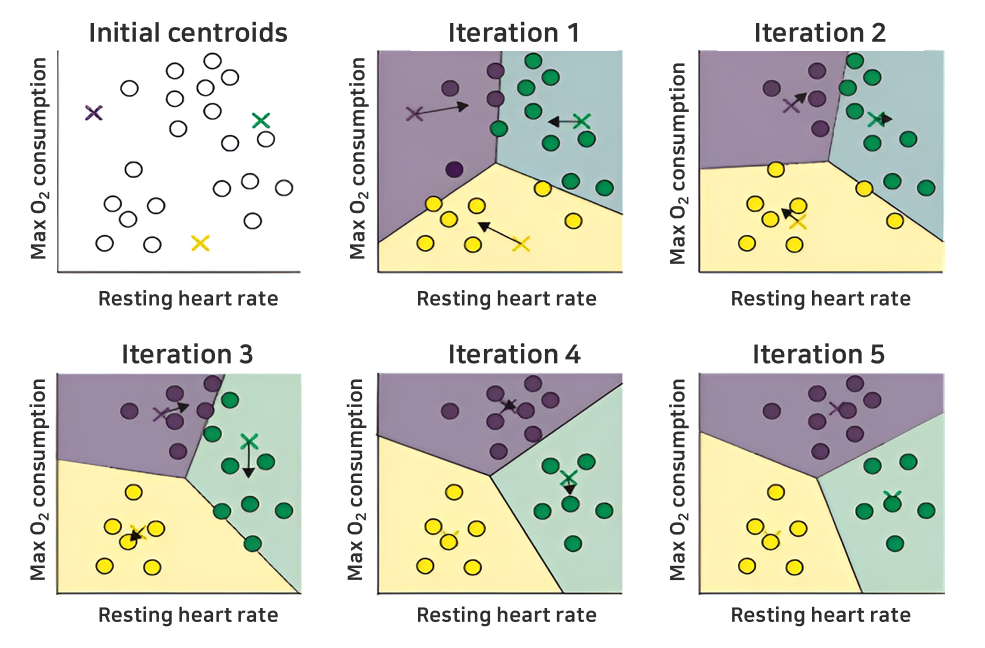

- 초기 중심에 민감하다.
    - 초기중심을 정해야하는 부분이 숙제!!
    - 랜덤하게 지정된 초기중심에 따라 결과가 많이 달라진다
- K-means++
    - 초기 중심점 선정의 어려움을 해결하기 위한 방법
        - 랜덤하게 1개의 데이터샘플을 중심점으로 선택
        - 해당 샘플과 가장 먼 샘플을 2번째 중심점으로 선택
        - 이 과정을 k 개가 될때까지 반복 후 군집화 진행한다.

- KMeans 클래스 주요 파라미터
    - random_state
        - 시드값
    - n_clusters
        - 군집수(K를 의미)
    - init
        - 초기 중심점 선정방법
        - 'k-means++'(기본값) , 'random'

In [78]:
target.nunique()

2

In [88]:
from sklearn.cluster import KMeans
cluster = KMeans(300, random_state=SEED)
cluster.fit(train_brand) # 학습

KMeans(n_clusters=300, random_state=42)

In [96]:
cluster_list = []
from sklearn.metrics import silhouette_score

for i in range(20, 50):
    cluster = KMeans(i, random_state=SEED)
    cluster.fit(train_brand) # 학습
    score = silhouette_score(train_brand, cluster.labels_)
    cluster_list.append((i, score))

cluster_list


[(20, 0.16387446885284968),
 (21, 0.18013470958704977),
 (22, 0.18560697029229495),
 (23, 0.19997275972803852),
 (24, 0.21574206323396364),
 (25, 0.23068866968300147),
 (26, 0.22731563290397575),
 (27, 0.2428174701818728),
 (28, 0.25421529255649755),
 (29, 0.2511346986143706),
 (30, 0.2688083849231082),
 (31, 0.2521771862635258),
 (32, 0.26758221452319836),
 (33, 0.27697797587767187),
 (34, 0.27899142034572105),
 (35, 0.2732964610107792),
 (36, 0.2688544400819291),
 (37, 0.27108055400576725),
 (38, 0.26588713657451585),
 (39, 0.257418297670904),
 (40, 0.259412742860301),
 (41, 0.2568552252194198),
 (42, 0.25471559684554307),
 (43, 0.22823923047466516),
 (44, 0.22994529266686617),
 (45, 0.229025008471724),
 (46, 0.2299497899922562),
 (47, 0.22270444232301456),
 (48, 0.22132740075781965),
 (49, 0.20774358258356806)]

In [181]:
from sklearn.cluster import KMeans
cluster = KMeans(150, random_state=SEED)
cluster.fit(train_brand) # 학습

KMeans(n_clusters=150, random_state=42)

- 학습데이터의 각 샘플에 대한 군집번호

In [182]:
cluster.labels_

array([  5,  13, 125, ...,  15,  32,  57], dtype=int32)

In [183]:
len(cluster.labels_)

1830

# 추가

In [184]:
train_brand_result["cluster_label"] = cluster.labels_
train_brand_result = train_brand_result[["브랜드코드", "cluster_label"]]

In [218]:
train_brand_result

브랜드코드  cluster_label
0      5100              5
1      5101             13
2      5102            125
3      5103              9
4      5104             13
...     ...            ...
1825   6990             33
1826   6992            123
1827   6994             15
1828   6995             32
1829   6996             57

[1830 rows x 2 columns]

In [219]:
train_tr = train_tr.merge(train_brand_result, on = "브랜드코드", how = "left")
train_tr

ID                 구매일시     지점코드     대분류      중분류  브랜드코드  \
0       train_13219  2004-05-01 09:40:00  A144000   공산품파트       차류   5100   
1        train_5590  2004-05-01 09:40:00  A144000    잡화파트     화장잡화   5101   
2        train_7200  2004-05-01 10:20:00  A112000     공산품     용기보증   5100   
3        train_3010  2004-05-01 10:30:00  A373000  아동_스포츠      아동복   5105   
4       train_10851  2004-05-01 10:30:00  A112000    가정용품  전화기_카세트   5110   
...             ...                  ...      ...     ...      ...    ...   
523100    train_330  2005-04-29 19:53:00  A112000    영캐릭터   트렌드캐주얼   5882   
523101   train_9738  2005-04-29 19:54:00  A373000  아동_스포츠   상품군미지정   5191   
523102  train_10787  2005-04-29 20:00:00  A112000     공산품       음료   5100   
523103  train_13129  2005-04-29 20:00:00  A112000     생식품     용기보증   5100   
523104    train_330  2005-04-29 20:03:00  A112000    영캐릭터   베이직캐주얼   5316   

          구매가격         구매일  구매월  구매요일  구매시간   수정_중분류  cluster_label  
0        59700  2004-05-01    5     5     9       차류              5  
1        17000  2004-05-01    5     5     9     화장잡화             13  
2        34937  2004-05-01    5     5    10     용기보증              5  
3        19000  2004-05-01    5     5    10      아동복             92  
4       215000  2004-05-01    5     5    10  전화기_카세트             68  
...        ...         ...  ...   ...   ...      ...            ...  
523100  484000  2005-04-29    4     4    19   트렌드캐주얼              8  
523101  144000  2005-04-29    4     4    19   상품군미지정             23  
523102    8340  2005-04-29    4     4    20       음료              5  
523103   23170  2005-04-29    4     4    20     용기보증              5  
523104  506000  2005-04-29    4     4    20   베이직캐주얼              8  

[523105 rows x 13 columns]

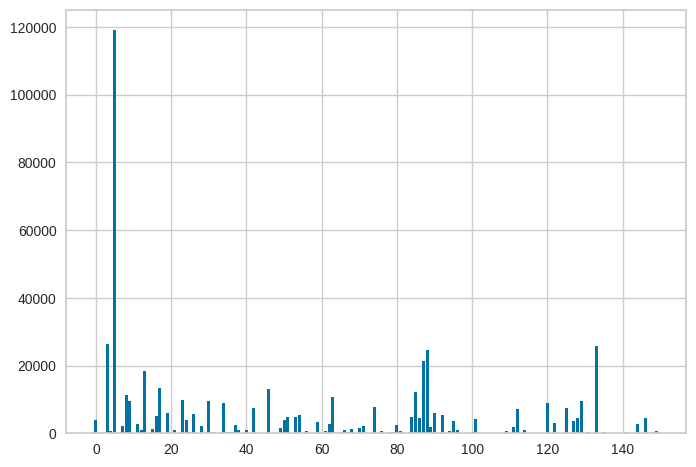

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.bar(train_tr["cluster_label"].value_counts().index, height = train_tr["cluster_label"].value_counts())
plt.show()

In [212]:
test_tr = test_tr.merge(train_brand_result, on = "브랜드코드", how = "left")
test_tr

ID                 구매일시     지점코드    대분류      중분류  브랜드코드  \
0        test_3366  2004-05-01 10:20:00  A373000    생식품      건식품   5100   
1        test_9389  2004-05-01 10:23:00  A373000   명품잡화      스타킹   5104   
2        test_8190  2004-05-01 10:30:00  A144000   잡화파트  수입종합화장품   5106   
3        test_8835  2004-05-01 10:30:00  A144000   잡화파트      준보석   5107   
4        test_1167  2004-05-01 10:30:00  A373000   남성의류       셔츠   5108   
...            ...                  ...      ...    ...      ...    ...   
441191  test_10274  2005-04-29 19:53:00  A112000   패션잡화  수입종합화장품   5149   
441192   test_8294  2005-04-29 19:53:00  A112000  여성캐주얼  칼라드래디셔널   6939   
441193  test_10919  2005-04-29 19:53:00  A112000   영플라자   스포츠캐주얼   5429   
441194    test_808  2005-04-29 19:53:00  A112000   남성의류       셔츠   5651   
441195  test_10919  2005-04-29 19:54:00  A112000   영플라자   스포츠캐주얼   5429   

          구매가격         구매일  구매월  구매요일  구매시간   수정_중분류  cluster_label  
0         7000  2004-05-01    5     5    10      건식품            5.0  
1        46000  2004-05-01    5     5    10      스타킹           13.0  
2       260000  2004-05-01    5     5    10  수입종합화장품           13.0  
3        17000  2004-05-01    5     5    10      준보석          149.0  
4       138000  2004-05-01    5     5    10       셔츠           90.0  
...        ...         ...  ...   ...   ...      ...            ...  
441191   73000  2005-04-29    4     4    19  수입종합화장품          133.0  
441192  188000  2005-04-29    4     4    19  칼라드래디셔널           16.0  
441193   39000  2005-04-29    4     4    19   스포츠캐주얼           87.0  
441194  160000  2005-04-29    4     4    19       셔츠           59.0  
441195   27300  2005-04-29    4     4    19   스포츠캐주얼           87.0  

[441196 rows x 13 columns]

In [220]:
test_tr

ID                 구매일시     지점코드    대분류      중분류  브랜드코드  \
0        test_3366  2004-05-01 10:20:00  A373000    생식품      건식품   5100   
1        test_9389  2004-05-01 10:23:00  A373000   명품잡화      스타킹   5104   
2        test_8190  2004-05-01 10:30:00  A144000   잡화파트  수입종합화장품   5106   
3        test_8835  2004-05-01 10:30:00  A144000   잡화파트      준보석   5107   
4        test_1167  2004-05-01 10:30:00  A373000   남성의류       셔츠   5108   
...            ...                  ...      ...    ...      ...    ...   
441191  test_10274  2005-04-29 19:53:00  A112000   패션잡화  수입종합화장품   5149   
441192   test_8294  2005-04-29 19:53:00  A112000  여성캐주얼  칼라드래디셔널   6939   
441193  test_10919  2005-04-29 19:53:00  A112000   영플라자   스포츠캐주얼   5429   
441194    test_808  2005-04-29 19:53:00  A112000   남성의류       셔츠   5651   
441195  test_10919  2005-04-29 19:54:00  A112000   영플라자   스포츠캐주얼   5429   

          구매가격         구매일  구매월  구매요일  구매시간   수정_중분류  cluster_label  
0         7000  2004-05-01    5     5    10      건식품            5.0  
1        46000  2004-05-01    5     5    10      스타킹           13.0  
2       260000  2004-05-01    5     5    10  수입종합화장품           13.0  
3        17000  2004-05-01    5     5    10      준보석          149.0  
4       138000  2004-05-01    5     5    10       셔츠           90.0  
...        ...         ...  ...   ...   ...      ...            ...  
441191   73000  2005-04-29    4     4    19  수입종합화장품          133.0  
441192  188000  2005-04-29    4     4    19  칼라드래디셔널           16.0  
441193   39000  2005-04-29    4     4    19   스포츠캐주얼           87.0  
441194  160000  2005-04-29    4     4    19       셔츠           59.0  
441195   27300  2005-04-29    4     4    19   스포츠캐주얼           87.0  

[441196 rows x 13 columns]

In [200]:
no_brand = test_tr[test_tr["cluster_label"].isnull() == True]
no_brand["브랜드코드"].unique()

array([5846, 5830, 5924, 5970, 6159, 6268, 6009, 6302, 6332, 6181, 6410,
       6436, 6474, 6477, 6521, 6545, 6553, 6573, 6618, 6658, 6659, 6703,
       6720, 6692, 6780, 6781, 6819, 6832, 6851, 6854, 6859, 6877, 6895,
       6889, 6202, 6915, 6950, 6998])

In [202]:
test_tr["cluster_label"].isnull().sum()

73

In [213]:
test_tr["cluster_label"] = test_tr["cluster_label"].fillna(151)
test_tr.isnull().sum()

ID               0
구매일시             0
지점코드             0
대분류              0
중분류              0
브랜드코드            0
구매가격             0
구매일              0
구매월              0
구매요일             0
구매시간             0
수정_중분류           0
cluster_label    0
dtype: int64

# 브랜드코드 특성 추가

In [221]:
agg_list = [
             ('브랜드코드_cluster_nunique', 'nunique'),
             ('주구매_브랜드_cluster', lambda x: x.mode()[0]),
             ]

tmp = train_tr.groupby('ID')["cluster_label"].agg(agg_list).reset_index()
train_ft = train_ft.merge(tmp, how='left',on="ID")
train_ft.head()

ID  구매횟수  내점일수  구매주기    봄_구매비율   여름_구매비율   가을_구매비율   겨울_구매비율  주구매요일  \
0  train_0    16    11    23  0.050000  0.250000  0.400000  0.300000      3   
1  train_1    41    21    16  0.357143  0.166667  0.357143  0.119048      3   
2  train_2   102    56     6  0.464912  0.140351  0.175439  0.219298      0   
3  train_3   191    92     3  0.379147  0.180095  0.236967  0.203791      3   
4  train_4    55    27    11  0.112903  0.612903  0.209677  0.064516      4   

   12시이전구매비율  ...         체류시간   구매당체류시간  지점코드별체류시간_A112000  \
0   0.300000  ...   474.545455  0.395455             3420.0   
1   0.214286  ...  2028.571429  0.804989            22620.0   
2   0.122807  ...  1549.285714  0.226504                0.0   
3   0.161137  ...  3161.086957  0.249691            30000.0   
4   0.096774  ...  1800.000000  0.483871                0.0   

   지점코드별체류시간_A144000  지점코드별체류시간_A202000  지점코드별체류시간_A373000  sin_time  \
0             1800.0                0.0                0.0 -0.546020   
1             3600.0                0.0             4380.0 -0.561980   
2             1200.0                0.0            53280.0 -0.631396   
3           203820.0                0.0            13920.0 -0.648557   
4            40200.0                0.0             8400.0 -0.656548   

   cos_time  브랜드코드_cluster_nunique  주구매_브랜드_cluster  
0 -0.566481                     13              129  
1 -0.518626                     15               87  
2 -0.584576                     31               42  
3 -0.495115                     38               88  
4 -0.533928                     17                5  

[5 rows x 445 columns]

In [215]:
tmp = test_tr.groupby('ID')["cluster_label"].agg(agg_list).reset_index()
test_ft = test_ft.merge(tmp, how='left',on="ID")
test_ft.head()

ID  구매횟수  내점일수  구매주기    봄_구매비율   여름_구매비율   가을_구매비율   겨울_구매비율  주구매요일  \
0  test_0     7     5    32  0.285714  0.285714  0.428571  0.000000      1   
1  test_1     4     3    54  0.000000  0.000000  0.750000  0.250000      0   
2  test_2     4     2     8  0.000000  0.600000  0.400000  0.000000      0   
3  test_3    28    16    16  0.062500  0.468750  0.343750  0.125000      3   
4  test_4    19     9    29  0.380952  0.285714  0.238095  0.095238      6   

   12시이전구매비율  ...         체류시간   구매당체류시간  지점코드별체류시간_A112000  \
0   0.142857  ...  1080.000000  2.571429                0.0   
1   0.250000  ...   200.000000  0.833333                0.0   
2   0.400000  ...   600.000000  2.000000                0.0   
3   0.000000  ...  1057.500000  0.550781            16920.0   
4   0.000000  ...  1653.333333  1.312169             3480.0   

   지점코드별체류시간_A144000  지점코드별체류시간_A202000  지점코드별체류시간_A373000  sin_time  \
0                0.0             5400.0                0.0 -0.389249   
1                0.0                0.0              600.0 -0.570060   
2             1200.0                0.0                0.0 -0.476028   
3                0.0                0.0                0.0 -0.907470   
4             4200.0                0.0             7200.0 -0.884016   

   cos_time  브랜드코드_cluster_nunique  주구매_브랜드_cluster  
0 -0.891005                      4              5.0  
1 -0.607963                      4             16.0  
2 -0.541662                      5              3.0  
3 -0.192915                     10              9.0  
4 -0.152899                      8             87.0  

[5 rows x 445 columns]

In [222]:
train_ft.shape, test_ft.shape

((14940, 445), (12225, 445))

In [224]:
#추가

#대분류, 구매가격 pivot 추가

train_tmp = pd.pivot_table(train_tr,index="ID",columns="cluster_label",values="구매가격",aggfunc="count",fill_value=0).add_prefix("브랜드_cluster_pivot_횟수비율").reset_index()
for col in train_tmp.columns[1:]:
    train_tmp[col] = train_tmp[col]/train_ft["구매횟수"]
train_ft = train_ft.merge(train_tmp,how="left",on="ID")
train_ft.head()
test_tmp = pd.pivot_table(test_tr,index="ID",columns="cluster_label",values="구매가격",aggfunc="count",fill_value=0).add_prefix("브랜드_cluster_pivot_횟수비율").reset_index()
for col in test_tmp.columns[1:]:
    test_tmp[col] = test_tmp[col]/test_ft["구매횟수"]
test_tmp.head()

for col in train_tmp.columns:
    if col not in test_tmp.columns:
        test_tmp[col] = 0

test_tmp = test_tmp[train_tmp.columns]

test_ft = test_ft.merge(test_tmp,how="left",on="ID")
test_ft.head()

<ipython-input-224-13e3dce16d1b>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_tmp[col] = 0
<ipython-input-224-13e3dce16d1b>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_tmp[col] = 0
<ipython-input-224-13e3dce16d1b>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_tmp[col] = 

ID  구매횟수  내점일수  구매주기    봄_구매비율   여름_구매비율   가을_구매비율   겨울_구매비율  주구매요일  \
0  test_0     7     5    32  0.285714  0.285714  0.428571  0.000000      1   
1  test_1     4     3    54  0.000000  0.000000  0.750000  0.250000      0   
2  test_2     4     2     8  0.000000  0.600000  0.400000  0.000000      0   
3  test_3    28    16    16  0.062500  0.468750  0.343750  0.125000      3   
4  test_4    19     9    29  0.380952  0.285714  0.238095  0.095238      6   

   12시이전구매비율  ...  브랜드_cluster_pivot_횟수비율140  브랜드_cluster_pivot_횟수비율141  \
0   0.142857  ...                          0                          0   
1   0.250000  ...                          0                          0   
2   0.400000  ...                          0                          0   
3   0.000000  ...                          0                          0   
4   0.000000  ...                          0                          0   

   브랜드_cluster_pivot_횟수비율142  브랜드_cluster_pivot_횟수비율143  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   브랜드_cluster_pivot_횟수비율144  브랜드_cluster_pivot_횟수비율145  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   브랜드_cluster_pivot_횟수비율146  브랜드_cluster_pivot_횟수비율147  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   브랜드_cluster_pivot_횟수비율148  브랜드_cluster_pivot_횟수비율149  
0                          0                          0  
1                          0                          0  
2                          0                          0  
3                          0                          0  
4                          0                          0  

[5 rows x 595 columns]

In [225]:
train_ft.shape, test_ft.shape

((14940, 595), (12225, 595))

#저장

In [227]:
train_ft.to_csv(f"{DATA_PATH}train_ft_군집분석_150.csv", index=False)
test_ft.to_csv(f"{DATA_PATH}test_ft_군집분석_150.csv", index=False)

- 예측도 가능!!

In [90]:
# cluster.predict(test_ft)

## 대표적인 군집화 성능 평가지표
- 군집화가 얼마나 잘되었는지 정량적으로 확인

### 사전에 정의된 그룹이 있는 경우
- 군집화 결과가 얼마나 사전에 정의된 그룹을 설명하는가를 평가
- 예시로 정답클래스가 있는 경우 얼마나 각 클래스처럼 그룹화가 되어 있는가를 평가

- homogeneity_score 함수
    - 각 군집(예측값)이 동일한 클래스(실제값)로 구성되어 있는 정도(동질성)
        - 정밀도와 비슷하다.
        - 0 ~ 1 값이며, 1에 가까울수록 군집화가 잘되었다는 의미

In [83]:
from sklearn.metrics import homogeneity_score
homogeneity_score(target, cluster.labels_)

ValueError: Found input variables with inconsistent numbers of samples: [14940, 1830]

- completeness_score 함수
    - 각 클래스(실제값)에 대하여 동일한 군집(예측값)으로 구성되어 있는 정도(완전성)
        - 재현율과 비슷하다.
        - 0 ~ 1 값이며, 1에 가까울수록 군집화가 잘되었다는 의미

In [26]:
from sklearn.metrics import completeness_score
completeness_score(target, cluster.labels_)

0.03247854600045898

- v_measure_score 함수
    - homogeneity 와 completeness의 조화평균
        - 0 ~ 1 값이며, 1에 가까울수록 군집화가 잘되었다는 의미

In [27]:
from sklearn.metrics import v_measure_score
v_measure_score(target, cluster.labels_)

0.059854318689739054

### 사전에 정의된 그룹이 없는 경우
- 대표적으로 실루엣 계수(silhouette coefficient)가 있다.
    - 군집 내의 거리는 짧을수록 군집 간의 거리가 길수록 좋은 군집화라는 가정을 평가하기 위한 지표
    - -1 ~ 1 의 값을 가진다.
    - 1에 가까울수록 최상의 군집화 되었다는 것을 의미
    - 0 에 가까울수록 군집간의 거리가 가까워지고 겹친다는 것을 의미
    - 음수일경우 잘못된 방식으로 군집화 되었다는 의미

In [160]:
from sklearn.metrics import silhouette_score
silhouette_score(train_brand, cluster.labels_)

0.15491122532500137

In [92]:
from sklearn.metrics import silhouette_samples
scores = silhouette_samples(train_brand, cluster.labels_)
scores.mean()

0.14049155089660206

In [93]:
scores.min()

-0.2614832576765993

## MiniBatchKMeans 클래스
- Mini-Batch 개수 만큼 무작위로 분리하여 K-means 군집화를 한다.
- 결과가 완전 똑같지는 않지만 k-means 와 비슷하게 나온다.
- 속도가 미니배치 방식이 빠르다.

In [161]:
from sklearn.cluster import MiniBatchKMeans
cluster = MiniBatchKMeans(150, random_state=SEED, batch_size=32)
cluster.fit(train_brand)

MiniBatchKMeans(batch_size=32, n_clusters=150, random_state=42)

In [163]:
silhouette_score(train_brand, cluster.labels_)

0.10324466669088553

In [ ]:
v_measure_score(target, cluster.labels_)

0.006115333798162854

## DBSCAN(Density-based spatial clustering of applications with noise)

- 밀도 기반 군집화의 대표적인 알고리즘으로 데이터 밀도 차이를 기반으로 하고 있어 복잡한 기하학적 분포도를 가진 데이터에 대해서도 군집화를 잘 수행하는 기법
1. 랜덤하게 데이터포인트들을 확인하고 지정한 반경 내에 지정한 최소개수만큼의 데이터가 포함되어 있으면
군집화가 되면서 해당 데이터포인트는 핵심포인트가 됨
2. 핵심포인트가 서로 연결(서로 반경 내에 포함)된다면
같은 군집으로 묶임
3. 연결되지 못하거나 최소 군집크기를 충족 못하면 노이즈로 분류됨
4. 모든 데이터포인트가 군집화, 노이즈가 될 때 까지 반복함



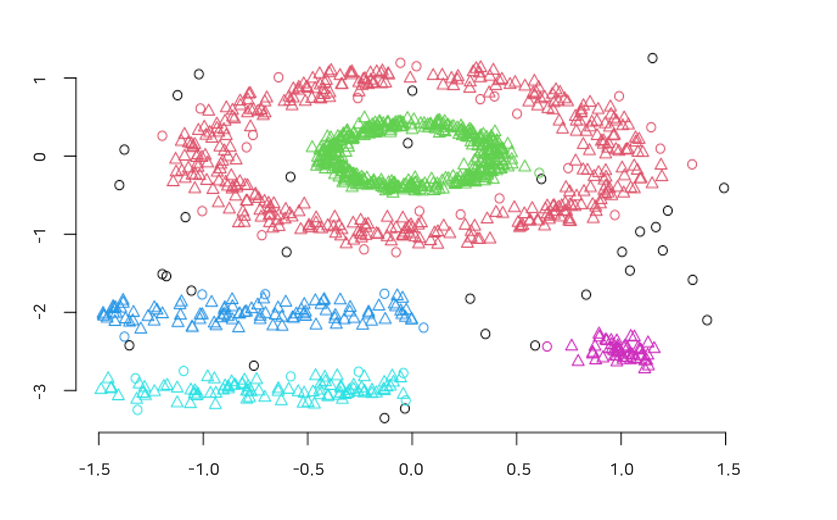

- DBSCAN 클래스 주요 파라미터
    - eps
        - 이웃으로 판단하는 최대 거리(반경)
    - min_samples
        - 이웃 반경 내 최소 샘플 수
    - predict 메서드 없음!!

In [172]:
train_brand

브랜드코드       거래횟수      내점일수      구매주기    봄_구매비율   여름_구매비율   가을_구매비율  \
0    -1.704956  29.513716  2.863063 -0.545609 -0.060199 -0.143344  0.026247   
1    -1.703121   0.813444  2.361760 -0.545609  0.123118 -0.216438 -0.142208   
2    -1.701287   0.102528  0.991533 -0.446041  0.152968 -0.388427  0.074253   
3    -1.699452   0.130777  1.080653 -0.446041 -0.397329 -0.044388  0.067419   
4    -1.697617   2.274509  2.562281 -0.545609  0.056494 -0.799826  0.553087   
...        ...        ...       ...       ...       ...       ...       ...   
1825  1.762556  -0.325904 -0.868858 -0.545609  2.967717 -1.110561 -1.035356   
1826  1.766226  -0.327474 -0.857718 -0.645177  2.967717 -1.110561 -1.035356   
1827  1.769895  -0.308641 -0.824298 -0.545609  2.967717 -1.110561 -1.035356   
1828  1.771730  -0.330612 -0.879998 -0.645177  2.967717 -1.110561 -1.035356   
1829  1.773564  -0.310211 -0.824298 -0.545609  2.967717 -1.110561 -1.035356   

       겨울_구매비율     주구매요일  12시이전구매비율  ...  주구매_대분류_16  주구매_대분류_17  주구매_대분류_18  \
0     0.211321  0.696640  -0.005488  ...   -0.155121   -0.254111   -0.236585   
1     0.265768  0.696640  -0.110533  ...   -0.155121   -0.254111   -0.236585   
2     0.216678  0.043874   0.214338  ...   -0.155121   -0.254111   -0.236585   
3     0.427557  0.043874  -0.249878  ...   -0.155121   -0.254111   -0.236585   
4     0.326333  0.696640  -0.124041  ...   -0.155121   -0.254111   -0.236585   
...        ...       ...        ...  ...         ...         ...         ...   
1825 -0.931389 -1.261657   0.466821  ...   -0.155121   -0.254111   -0.236585   
1826 -0.931389 -0.608891  -1.288245  ...   -0.155121   -0.254111   -0.236585   
1827 -0.931389 -1.261657  -0.118201  ...   -0.155121   -0.254111   -0.236585   
1828 -0.931389  1.349406   5.732022  ...   -0.155121   -0.254111   -0.236585   
1829 -0.931389  2.002172   0.216098  ...   -0.155121   -0.254111   -0.236585   

      주구매_대분류_19  주구매_대분류_20  주구매_대분류_21  주구매_대분류_22  주구매_대분류_23  주구매_대분류_24  \
0      -0.160576   -0.197945   -0.126894   -0.115278   -0.180918   -0.133407   
1      -0.160576   -0.197945   -0.126894   -0.115278   -0.180918   -0.133407   
2      -0.160576   -0.197945   -0.126894   -0.115278   -0.180918   -0.133407   
3      -0.160576   -0.197945   -0.126894   -0.115278   -0.180918   -0.133407   
4      -0.160576   -0.197945   -0.126894   -0.115278   -0.180918   -0.133407   
...          ...         ...         ...         ...         ...         ...   
1825   -0.160576   -0.197945   -0.126894   -0.115278   -0.180918   -0.133407   
1826   -0.160576   -0.197945   -0.126894   -0.115278   -0.180918   -0.133407   
1827   -0.160576   -0.197945   -0.126894   -0.115278   -0.180918   -0.133407   
1828   -0.160576   -0.197945   -0.126894   -0.115278   -0.180918   -0.133407   
1829   -0.160576    5.051905   -0.126894   -0.115278   -0.180918   -0.133407   

      주구매_대분류_25  
0      -0.084585  
1      -0.084585  
2      -0.084585  
3      -0.084585  
4      -0.084585  
...          ...  
1825   -0.084585  
1826   -0.084585  
1827   -0.084585  
1828   -0.084585  
1829   -0.084585  

[1830 rows x 59 columns]

In [178]:
from sklearn.cluster import DBSCAN
cluster = DBSCAN(0.00005, min_samples=12, n_jobs=-1)
cluster.fit(train_brand)

DBSCAN(eps=5e-05, min_samples=12, n_jobs=-1)

In [179]:
np.unique(cluster.labels_).shape

(1,)

In [180]:
cluster.labels_

array([-1, -1, -1, ..., -1, -1, -1])

In [ ]:
silhouette_score(train_ft, cluster.labels_)

0.7371930757396534

## Agglomerative Clustering
- 가까운 군집들을 연결해 나가면서 계층적으로 군집화 하는 기법
- 모든 데이터에 대해서 각각의 독립적인 군집화를 하고 가까운 군집들을 병합하면서 군집 개수를 줄여 나간다.


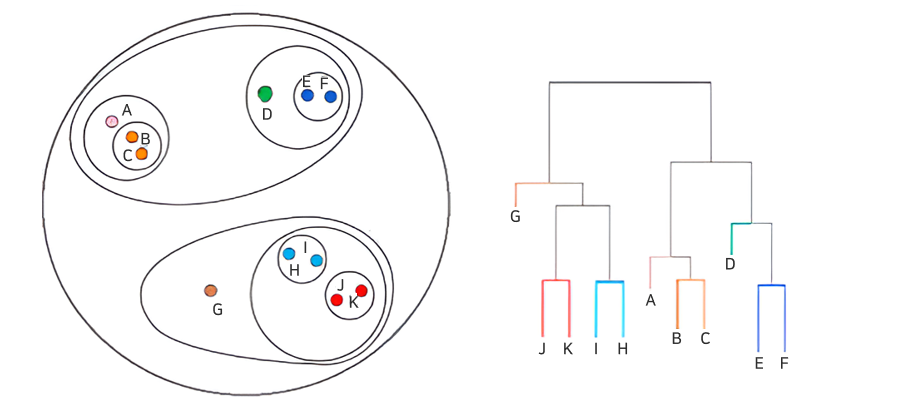

In [ ]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(7)
cluster.fit(train_ft)

AgglomerativeClustering(n_clusters=7)

In [ ]:
silhouette_score(train_ft, cluster.labels_)

0.40333717029910393

In [ ]:
# cluster.predict # 오류

# 실루엣 계수가 높은 k값 선택(비추천)

In [ ]:
for k in range(2,10):
    cluster = KMeans(k, random_state=SEED)
    cluster.fit(train_ft)
    score = silhouette_score(train_ft, cluster.labels_)
    print(k, score)

2 0.29257933985076884
3 0.24379840205983894
4 0.2836894397062517
5 0.30011073716766606
6 0.3492938164123864
7 0.41177112774476704
8 0.4574375986871392
9 0.5050615046570717


# 엘보우(elbow) 방법
- 군집 내 제곱합을 계산하여 K값을 선택하는 방법
- 제곱합(SSE)
    - 데이터 포인트와 해당 군집의 중심점 간의 거리의 제곱합을 의미
- K가 증가할 수록 SSE 값은 급격히 감소하다가 어느 순간부터 감소율이 둔화되는데 이 지점의 K값의 선택하는 방법

In [137]:
import matplotlib.pyplot as plt

In [149]:
sse_list = []
for k in range(100, 1001, 50):
    cluster = KMeans(k, random_state=SEED)
    cluster.fit(train_brand)
    sse_list.append(cluster.inertia_)

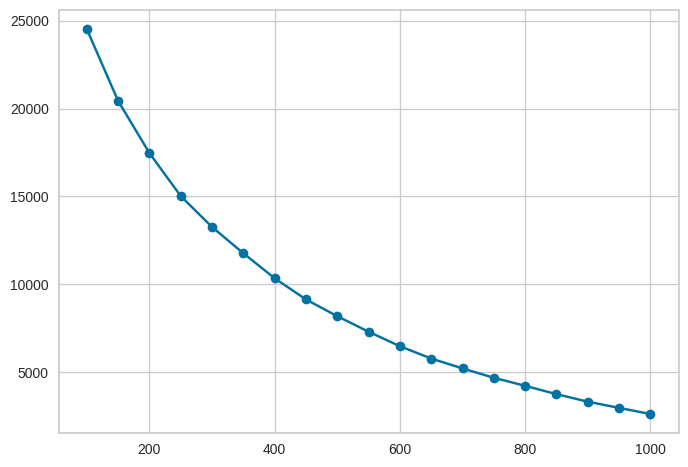

In [150]:
fig, ax = plt.subplots()
ax.plot(range(100, 1001, 50), sse_list, marker="o")
plt.show()

# yellowbrick
- 머신러닝 관련된 시각화에 특화된 라이브러리
- 사이킷런의 기능과 matplotlib 을 내부적으로 사용
- 설치하기
    ```bash
    pip install yellowbrick
    ```

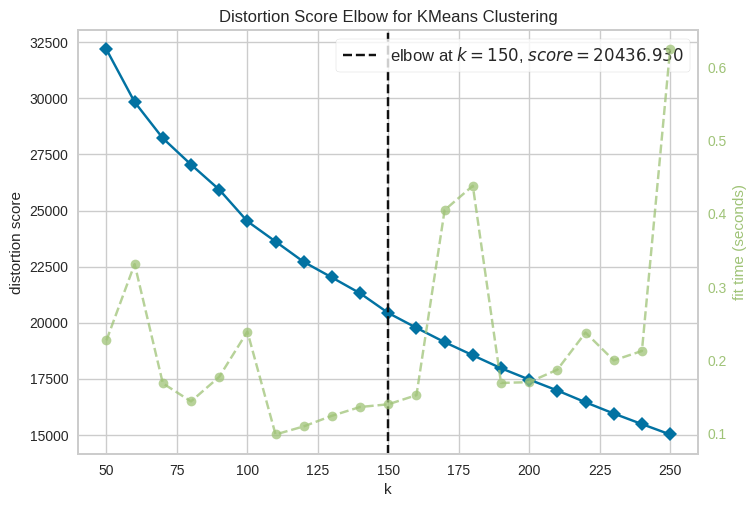

In [154]:
from yellowbrick.cluster import KElbowVisualizer

num_list = np.arange(50, 251, 10)
# 클러스터 객체, k 파라미터에 k 범위를 전달해주면 됨.
cluster = KMeans(random_state=SEED)
viz = KElbowVisualizer( cluster, k=num_list )
viz.fit(train_brand)
viz.show()
plt.show()

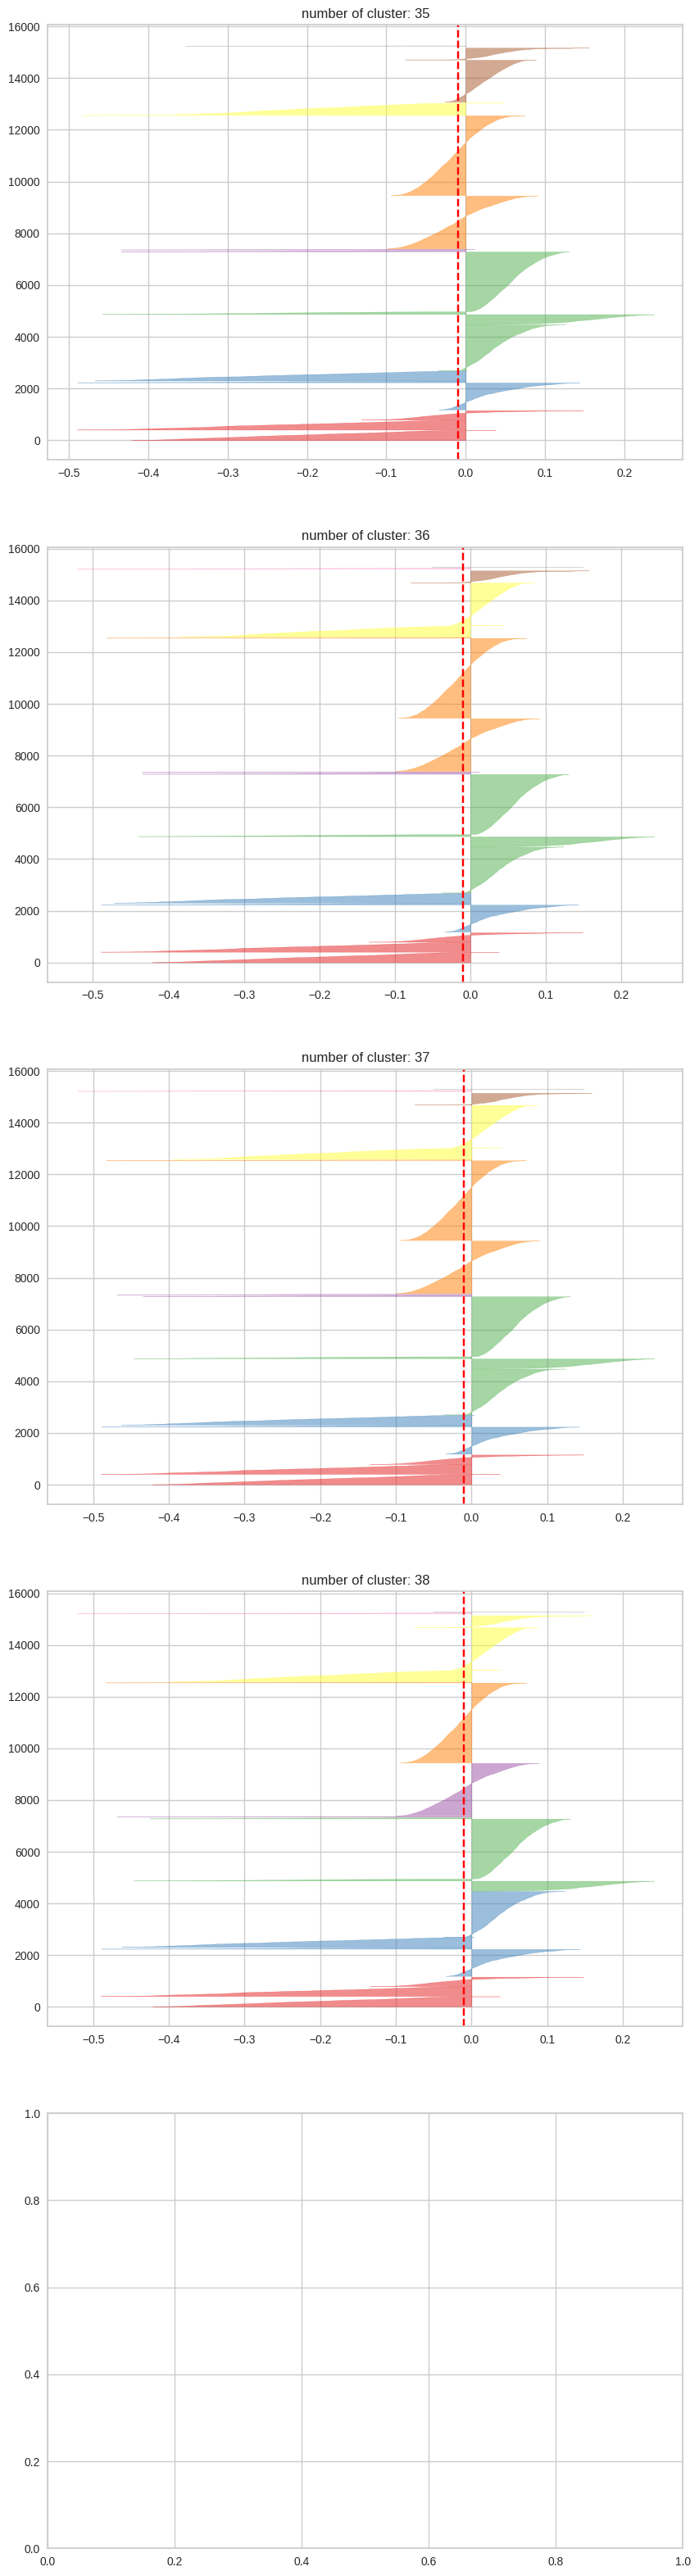

In [146]:
from yellowbrick.cluster import SilhouetteVisualizer
fig, ax = plt.subplots(5, figsize=(10,40) )
for i, k in enumerate(range(35,39)):
    cluster = KMeans(k, random_state=SEED)
    ax[i].set_title(f"number of cluster: {k}")
    viz = SilhouetteVisualizer(cluster, ax=ax[i])
    viz.fit(train_ft)
plt.show()

# 군집분석

In [ ]:
cluster = KMeans(13, random_state=SEED)
cluster.fit(train_ft)

KMeans(n_clusters=13, random_state=42)

In [ ]:
train["cluster"] = cluster.labels_
train.head()

ID  나이   연간소득 주택소유상태       근로기간  대출목적  대출금액    이자율  신용거래기간  target  \
0  train_0  26  33996     임대  10.000000    투자  7000   8.00       2       0   
1  train_1  34  84000     임대   3.000000  개인사업  9000   5.79      10       0   
2  train_2  22  24702     임대   4.810613    교육  2000  13.23       4       2   
3  train_3  24  69996     임대   3.000000  부채통합  2500  12.53       3       1   
4  train_4  26  58125   모기지론  10.000000    투자  6000  10.25       2       1   

   cluster  
0        1  
1        5  
2        3  
3        2  
4        8

In [ ]:
train["cluster"].value_counts()

cluster
4     2017
3     1978
2     1733
5     1668
0     1611
1     1601
9     1549
11    1394
6     1356
7     1350
8     1342
12    1030
10     919
Name: count, dtype: int64

# 군집별 시각화

In [ ]:
import matplotlib
from matplotlib import font_manager

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv

fontpaths = ["/usr/share/fonts/truetype/nanum/"]
font_files = font_manager.findSystemFonts(fontpaths=fontpaths)

for ff in font_files:
    font_manager.fontManager.addfont(ff)

matplotlib.rc('font', family="NanumGothic")
matplotlib.rcParams['axes.unicode_minus'] = False

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,566 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123622 files and dire

In [ ]:
import seaborn as sns

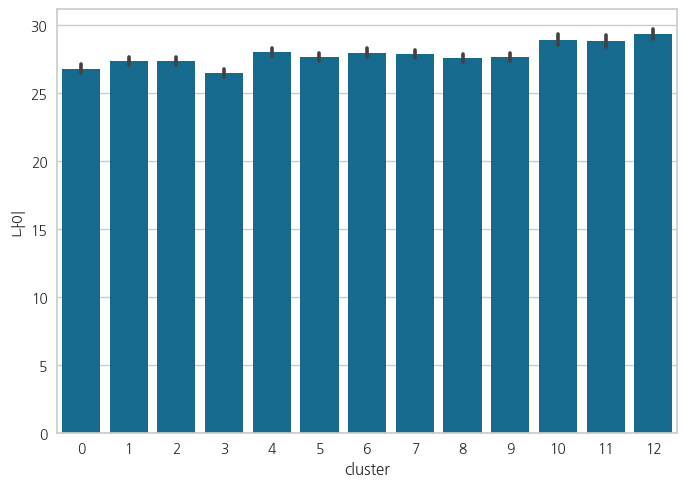

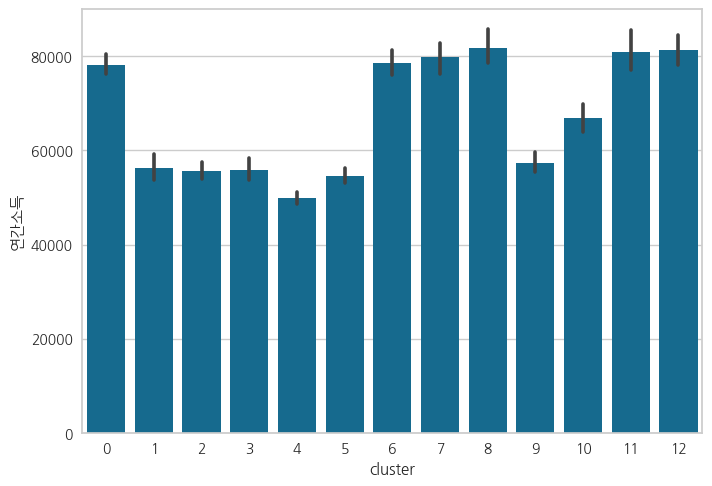

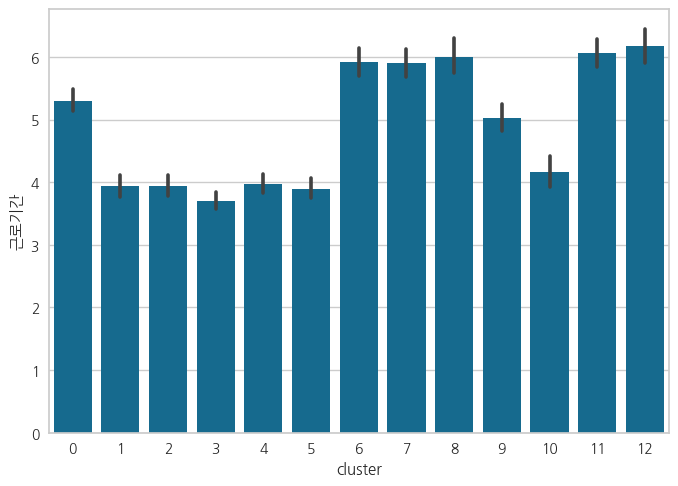

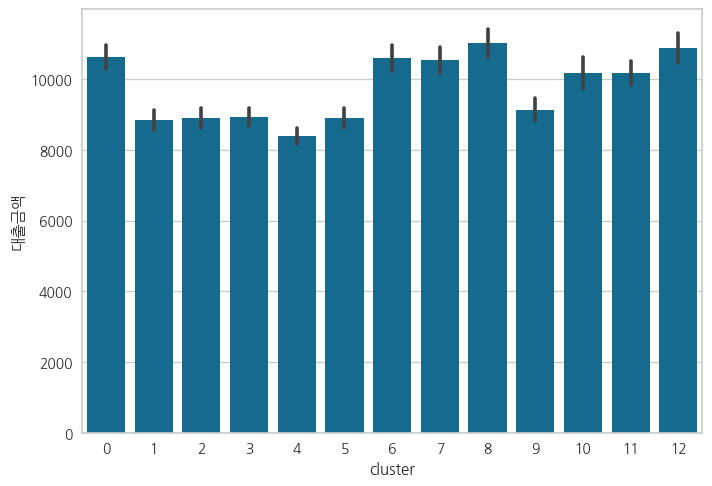

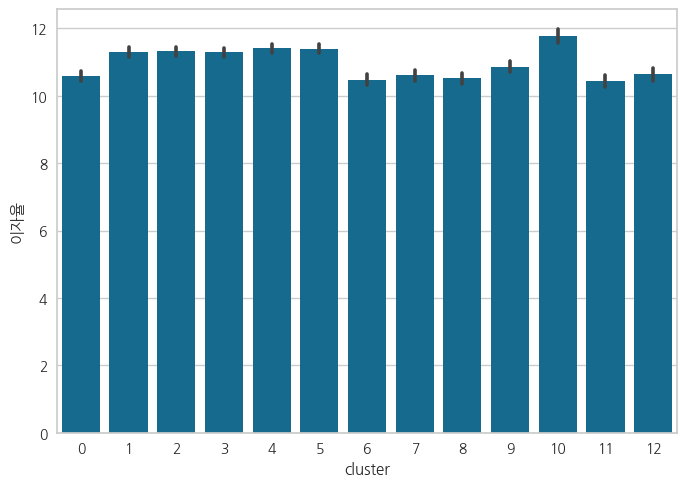

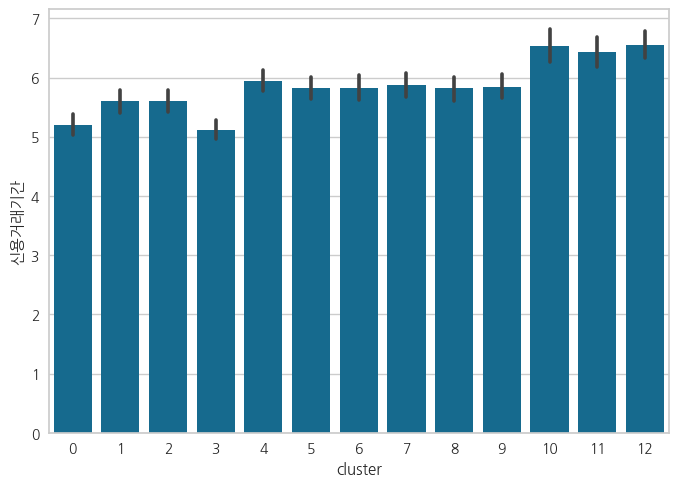

In [ ]:
cols_num = ["나이", "연간소득", "근로기간", "대출금액", "이자율", "신용거래기간"]

for col in cols_num:
    sns.barplot(train, x="cluster", y=col)
    plt.show()
    print()

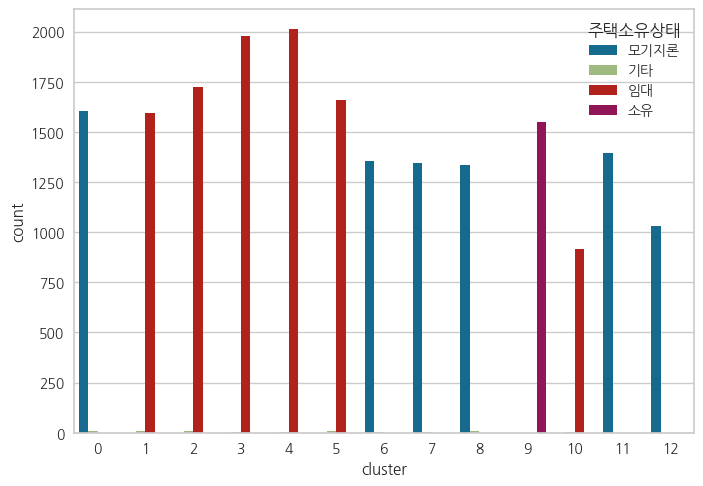

In [ ]:
sns.countplot(train, x="cluster", hue="주택소유상태")
plt.show()

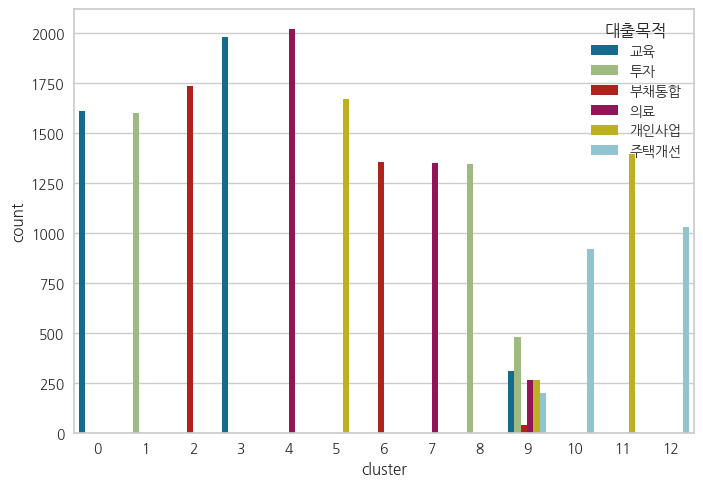

In [ ]:
sns.countplot(train, x="cluster", hue="대출목적")
plt.show()

In [ ]:
df_cluster = []
for i in range(13):
    mask = train["cluster"] == i
    tmp = train.loc[mask].reset_index(drop=True)
    df_cluster.append(tmp)

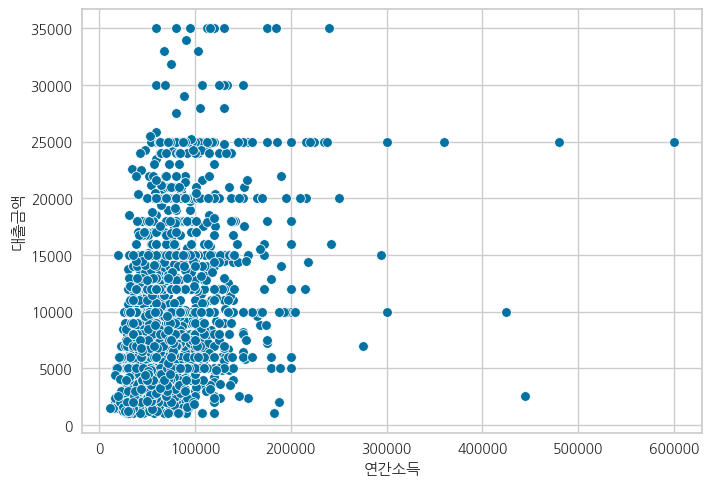

In [ ]:
sns.scatterplot(df_cluster[0], x="연간소득", y="대출금액")
plt.show()

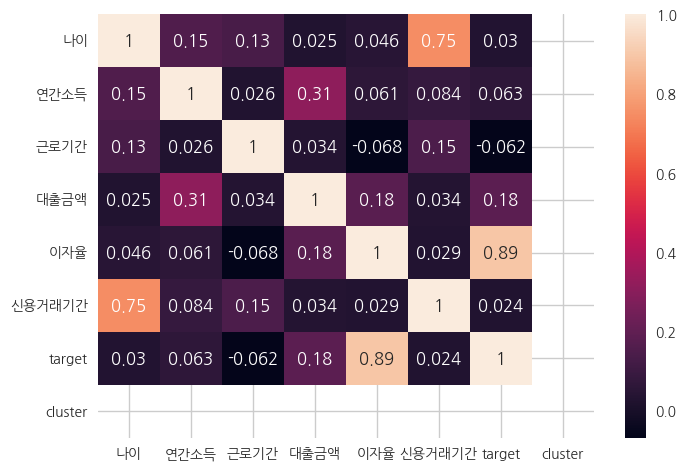

In [ ]:
sns.heatmap(df_cluster[0].corr(numeric_only=True), annot=True)
plt.show()

# 군집분석 응용 해보기

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/data/"

SEED = 42 # 시드값

# 데이터 블러오기
train = pd.read_csv(f"{DATA_PATH}titanic_train.csv") # 학습데이터
test = pd.read_csv(f"{DATA_PATH}titanic_test.csv") # 테스트 데이터

# 결측치 처리
age_mean = train["age"].mean()
fare_median = train["fare"].median()
cabin_unk = "UNK"
embarked_mode = train["embarked"].mode()[0]
train["age"] = train["age"].fillna(age_mean)
train["cabin"] = train["cabin"].fillna(cabin_unk)
test["age"] = test["age"].fillna(age_mean)
test["fare"] = test["fare"].fillna(fare_median)
test["cabin"] = test["cabin"].fillna(cabin_unk)
test["embarked"] = test["embarked"].fillna(embarked_mode)

# 특성으로 사용할 변수 선택
cols = ["age","sibsp","parch","fare","pclass","gender","embarked"]
train_ft = train[cols].copy()
test_ft = test[cols].copy()

# 범주형 변수 원핫인코딩
cols = ['gender','embarked']
enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(train[cols])
tmp = pd.DataFrame(
    enc.transform(train_ft[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
train_ft = pd.concat([train_ft,tmp],axis=1).drop(columns=cols)
tmp = pd.DataFrame(
    enc.transform(test_ft[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
test_ft = pd.concat([test_ft,tmp],axis=1).drop(columns=cols)

# Min-Max Scaling
scaler = MinMaxScaler()
scaler.fit(train_ft)
train_ft[train_ft.columns] = scaler.transform(train_ft)
test_ft[test_ft.columns] = scaler.transform(test_ft)

# 정답 데이터
target = train["survived"]

train_ft.shape, test_ft.shape, target.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


((916, 10), (393, 10), (916,))

In [ ]:
from lightgbm import LGBMClassifier
model = LGBMClassifier(random_state=SEED)
model.fit(train_ft, target)

[LightGBM] [Info] Number of positive: 346, number of negative: 570
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 916, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377729 -> initscore=-0.499198
[LightGBM] [Info] Start training from score -0.499198


LGBMClassifier(random_state=42)

In [ ]:
pred = model.predict(test_ft)
pred

array([0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,

```
K-means 모델을 이용해서 타이타닉 데이터에 대하여 학습을하고
test 데이터에 대하여 0 또는 1로 예측을 수행해주세요.
작성한 코드부분만 저한테 DM으로 주세요
```

In [ ]:
cluster = KMeans(2, random_state=SEED)
cluster.fit(train_ft)

KMeans(n_clusters=2, random_state=42)

In [ ]:
target.mean()

0.3777292576419214

In [ ]:
cluster.labels_.mean()

0.36681222707423583

In [ ]:
pred= cluster.predict(test_ft)
# (pred == 0).astype(int)
pred

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,

In [ ]:
pd.DataFrame(pred, columns=["target"]).to_csv("홍길동.csv")